In [1]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pprint import pprint
import math


In [2]:
# params
seed = 42

Данные существуют в виде нескольких отдельных таблиц, составлявших базу данных в соответствии со следующей картой: 
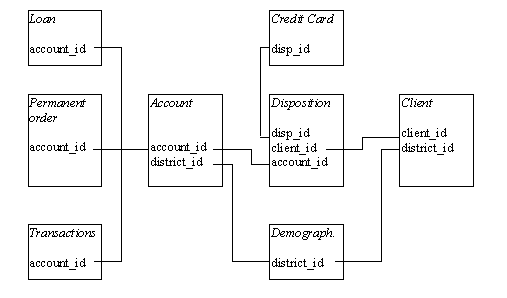

Другая схема приведена в [статье](https://towardsdatascience.com/loan-default-prediction-an-end-to-end-ml-project-with-real-bank-data-part-1-1405f7aecb9e):  
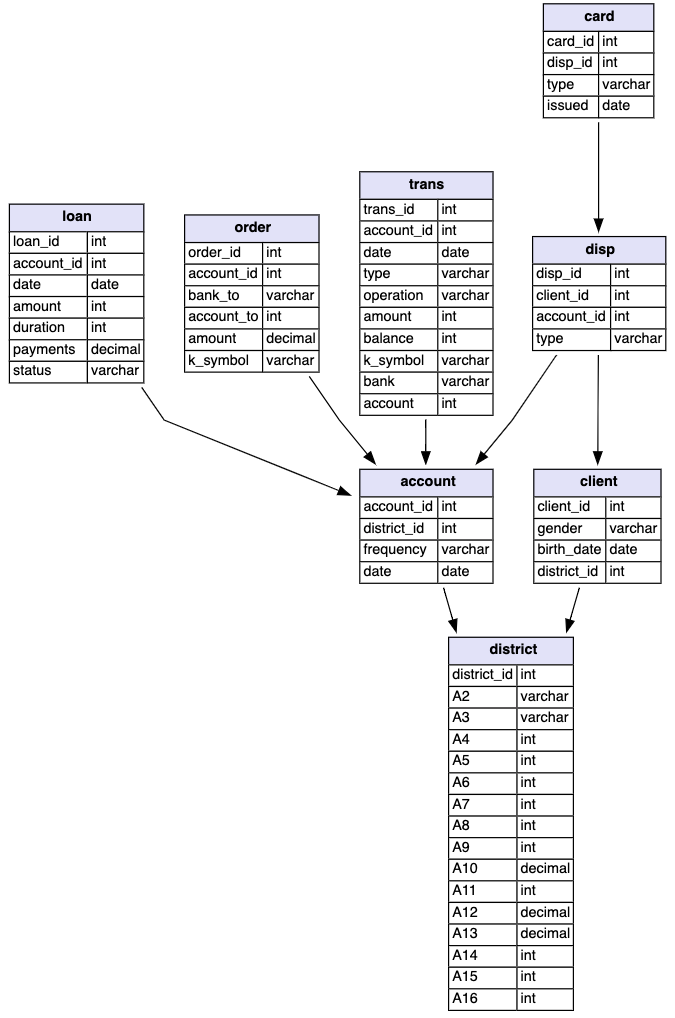

Там же дано описание таблиц: 

account (4500 objects in the file ACCOUNT.ASC) — each record describes static characteristics of an account.

client (5369 objects in the file CLIENT.ASC) — each record describes characteristics of a client.

disposition (5369 objects in the file DISP.ASC) — each record relates together a client with an account i.e. this relation describes the rights of clients to operate accounts.

permanent order (6471 objects in the file ORDER.ASC) — each record describes characteristics of a payment order.

transaction (1056320 objects in the file TRANS.ASC) — each record describes one transaction on an account.

loan (682 objects in the file LOAN.ASC) — each record describes a loan granted for a given account.

credit card (892 objects in the file CARD.ASC) — each record describes a credit card issued to an account.

demographic data (77 objects in the file DISTRICT.ASC) — each record describes demographic characteristics of a district.

Обратим внимание: таблица client (которая реально соответствует списку фичей в верхней схеме, а не нижней) по сути содержит только непонятный birth_number, который я вообще никак не могу идентифицировать, и связь между клиентом и районом. 
Объединим их.

In [316]:
dfs = [pd.read_csv("./Data_tables/" + table_name, sep = ";", low_memory = False) for table_name in os.listdir("./Data_tables")]

dfs_names = [table_name.replace(".csv", "") for table_name in os.listdir("./Data_tables")]

dfs = dict(zip(dfs_names, dfs))

In [360]:
#example of a table
merged_df["16"]

KeyError: '16'

Кстати, наблюдается проблема: в файле district нет ключа dist_id, но на него очень похожа переменная A1

In [325]:
dfs["district"]

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Opava,north Moravia,182027,17,49,12,2,7,56.4,8746,3.33,3.74,90,4355,4433
73,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
74,75,Prerov,north Moravia,138032,67,30,4,2,5,64.6,8819,5.38,5.66,99,4063,4505
75,76,Sumperk,north Moravia,127369,31,32,13,2,7,51.2,8369,4.73,5.88,107,3736,2807


In [36]:
#Создадим таблицу aggregated order, которая будет содержать данные, описывающие таблицу order, но при этом
#с уникальными значениями account_id
aggregated_order = dfs["order"].groupby("account_id").sum()
aggregated_order.drop(["account_to", "order_id"], axis = 1, inplace = True)
aggregated_order.columns = ["order_amount_sum"]

#purely quantitative column "amount"
temp = dfs["order"].groupby("account_id").mean()
aggregated_order["order_amount_mean"] = temp.amount
temp = dfs["order"].groupby("account_id").median()
aggregated_order["order_amount_median"] = temp.amount
temp = dfs["order"].groupby("account_id").min()
aggregated_order["order_amount_min"] = temp.amount
temp = dfs["order"].groupby("account_id").max()
aggregated_order["order_amount_max"] = temp.amount
temp = dfs["order"].groupby("account_id").std()
temp = temp.fillna(0)
aggregated_order["order_amount_sd"] = temp.amount

#qualitative columns bank_to, account_to, k_symbol

#most common value

temp = dfs["order"].groupby("account_id").agg(lambda x: x.value_counts().index[0])
temp
aggregated_order[["favourite_bank_to", "favourite_account_to", "favourite_k_symbol"]] = temp[["bank_to", "account_to", "k_symbol"]]

#weight of most common value

count = dfs["order"].groupby("account_id").count()
count_favourite = dfs["order"].groupby("account_id").agg(lambda x: x.value_counts().tolist()[0])
temp = count_favourite.div(count)
aggregated_order[["weight_favourite_bank_to", "weight_favourite_account_to", "weight_favourite_k_symbol"]] = temp[["bank_to", "account_to", "k_symbol"]]

#number of orders 

temp = dfs["order"].groupby("account_id").count()
aggregated_order["number_of_orders"] = temp["order_id"]

dfs["order"] = aggregated_order

In [159]:
#Создадим таблицу aggregated trans, которая будет содержать данные, описывающие таблицу trans, но при этом
#с уникальными значениями account_id

#purely quantitative columns "amount" and "balance"

aggregated_trans = dfs["trans"].groupby("account_id").sum()
aggregated_trans = aggregated_trans[["amount"]]
aggregated_trans.columns = ["trans_amount_sum"]

temp = dfs["trans"][["account_id", "amount", "balance"]]
temp["account_influence"] = temp.balance/temp.amount
dfs["trans"]["account_influence"] = temp["account_influence"]

temp = dfs["trans"].groupby("account_id").mean()
aggregated_trans[["trans_amount_mean", "trans_balance_mean", "transaction_account_influence_mean"]] = temp[["amount", "balance", "account_influence"]]
temp = dfs["trans"].groupby("account_id").median()
aggregated_trans[["trans_amount_median", "trans_balance_median", "transaction_account_influence_median"]] = temp[["amount", "balance", "account_influence"]]
temp = dfs["trans"].groupby("account_id")[["amount", "balance", "date", "account_influence"]].min()
aggregated_trans[["trans_amount_min", "trans_balance_min", "first_transaction_date", "transaction_account_influence_min"]] = temp[["amount", "balance", "date", "account_influence"]]
temp = dfs["trans"].groupby("account_id")["amount", "balance", "date", "account_influence"].max()
aggregated_trans[["trans_amount_max", "trans_balance_max", "transaction_account_influence_max"]] = temp[["amount", "balance", "account_influence"]]
temp = dfs["trans"].groupby("account_id").std()
temp = temp.fillna(0)
aggregated_trans[["trans_amount_sd", "trans_balance_sd", "transaction_account_influence_sd"]] = temp[["amount", "balance", "account_influence"]]


#qualitative columns type, operation, k_symbol

#most common value
def favourite(values):
    valuelist = values.value_counts().index
    if (len(valuelist) != 0):
        return valuelist[0]
    else:
        return None
    
temp = dfs["trans"].groupby("account_id").agg(lambda x: favourite(x))
temp
aggregated_trans[["favourite_trans_type", "favourite_trans_operation", "favourite_trans_k_symbol"]] = temp[["type", "operation", "k_symbol"]]

# #weight of most common value

def weight_favourite(values):
    valuelist = values.value_counts().tolist()
    if (valuelist == valuelist)&(len(valuelist) != 0):
        return valuelist[0]
    else:
        return None
count = dfs["trans"].groupby("account_id").count()
count_favourite = dfs["trans"].groupby("account_id").agg(lambda x: weight_favourite(x))
temp = count_favourite.div(count)
aggregated_trans[["weight_favourite_trans_type", "weight_favourite_trans_operation", "weight_favourite_trans_k_symbol"]] = temp[["type", "operation", "k_symbol"]]

# #count each category
count = pd.get_dummies(dfs["trans"][["type", "operation", "k_symbol"]], prefix = "number_of_trans_")
count["account_id"] = dfs["trans"]["account_id"]
count = count.groupby("account_id").sum()
aggregated_trans = pd.concat([aggregated_trans, count], axis = 1)

#check whether each category is nan
count = dfs["trans"][["type", "operation", "k_symbol"]].isnull().applymap(int)
count["account_id"] = dfs["trans"]["account_id"]
count = count.groupby("account_id").sum()
count.columns = ["trans_with_nan_type", "trans_with_nan_operation", "trans_with_nan_k"]
aggregated_trans = pd.concat([aggregated_trans, count], axis = 1)

#all the transformations related to date
#dfs["trans"].date = pd.to_datetime(dfs["trans"].date.apply(str), format = "%y%m%d")
dfs["trans"]["previous_date"] = dfs["trans"].groupby("account_id")["date"].shift()
dfs["trans"]["year"] = dfs["trans"].date.apply(lambda x: x.year)
dfs["trans"]["month"] = dfs["trans"].date.apply(lambda x: x.month)
dfs["trans"]["days_since_previous_trans"] = (dfs["trans"].date - dfs["trans"].previous_date).apply(lambda x: x.days)

#number of transactions per month
temp = dfs["trans"].groupby(["account_id", "month"]).count().groupby("account_id").mean()
aggregated_trans["trans_per_month_mean"] = temp[["trans_id"]]
aggregated_trans

#number of transactions per year
temp = dfs["trans"].groupby(["account_id", "year"]).count().groupby("account_id").mean()
aggregated_trans["trans_per_year_mean"] = temp[["trans_id"]]
aggregated_trans

#mean distance between consecutive transactions
temp = dfs["trans"].groupby("account_id").mean()
aggregated_trans["days_between_transactions_mean"] = temp[["days_since_previous_trans"]]
aggregated_trans

#month and year of the first transaction
temp = dfs["trans"].groupby("account_id")[["year", "month"]].min()
aggregated_trans[["first_trans_month", "first_trans_year"]] = temp[["month", "year"]]
aggregated_trans

#number of transs 

temp = dfs["trans"].groupby("account_id").count()
aggregated_trans["number_of_transactions"] = temp["trans_id"]

dfs["trans"] = aggregated_trans

<ipython-input-159-530ae78769db>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["account_influence"] = temp.balance/temp.amount
<ipython-input-159-530ae78769db>:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = dfs["trans"].groupby("account_id")["amount", "balance", "date", "account_influence"].max()


In [317]:
#Создадим таблицу aggregated cards, которая будет содержать данные, описывающие таблицу card, но при этом
#с уникальными значениями disp_id 

dfs["card"]["issued"] = pd.to_datetime(dfs["card"].issued.apply(str), format = "%y%m%d %H:%M:%S")

aggregated_card = dfs["card"].groupby("disp_id").count()[["card_id"]]
aggregated_card
aggregated_card.columns = ["num_of_cards_on_id"]

#most common value
def favourite(values):
    valuelist = values.value_counts().index
    if (len(valuelist) != 0):
        return valuelist[0]
    else:
        return None
    
temp = dfs["card"].groupby("disp_id").agg(lambda x: favourite(x))
temp
aggregated_card["favourite_card_type"] = temp["type"]
aggregated_card
#weight of most common value

def weight_favourite(values):
    valuelist = values.value_counts().tolist()
    if (valuelist == valuelist)&(len(valuelist) != 0):
        return valuelist[0]
    else:
        return None
    
count = dfs["card"].groupby("disp_id").count()
count_favourite = dfs["card"].groupby("disp_id").agg(lambda x: weight_favourite(x))
temp = count_favourite.div(count)
aggregated_card["weight_favourite_card_type"] = temp["type"]

# #count each category
count = pd.get_dummies(dfs["card"][["type"]], prefix = "number_of_card_")
count["disp_id"] = dfs["card"]["disp_id"]
count = count.groupby("disp_id").sum()
aggregated_card = pd.concat([aggregated_card, count], axis = 1)

#all the transformations related to date
#dfs["card"].date = pd.to_datetime(dfs["card"].date.apply(str), format = "%y%m%d")
dfs["card"]["previous_date"] = dfs["card"].groupby("disp_id")["issued"].shift()
dfs["card"]["year"] = dfs["card"].issued.apply(lambda x: x.year)
dfs["card"]["month"] = dfs["card"].issued.apply(lambda x: x.month)
dfs["card"]["days_since_previous_card"] = (dfs["card"].issued - dfs["card"].previous_date).apply(lambda x: x.days)

#month and year of the first card registration
temp = dfs["card"].groupby("disp_id")[["year", "month"]].min()
aggregated_card[["first_card_month", "first_card_year"]] = temp[["month", "year"]]
aggregated_card


dfs["card"] = aggregated_card

In [320]:
#Создадим таблицу aggregated disp, которая будет содержать данные, описывающие таблицу disp, но при этом
#с уникальными значениями disp_id 

aggregated_disp = dfs["disp"].groupby("disp_id").count()[["account_id"]]
aggregated_disp.columns = ["num_of_accounts_on_id"]
aggregated_disp = pd.concat([aggregated_disp, dfs["disp"].set_index("disp_id")], axis = 1)
aggregated_disp

#add previously processed card table and client personal data table to it
merged_disp = aggregated_disp.reset_index().merge(dfs["card"], on = "disp_id", how = "left")
merged_disp = merged_disp.merge(dfs["client"][["client_id", "district_id"]], on = "client_id", how = "left")
merged_disp
#now make this merged table unique on account_id
aggregated_disp = merged_disp.groupby("account_id").count()[["disp_id"]]
merged_disp.drop("disp_id", axis = 1, inplace = True)
aggregated_disp.columns = ["num_of_users_of_account"]
aggregated_disp

#count disponents of each account

def count_disponents(values):
    return (values == "DISPONENT").sum()
aggregated_disp["number_of_disponents"] = merged_disp.groupby("account_id").agg(lambda x: count_disponents(x))["type"]
    
#remove the disponents from the table
merged_disp = merged_disp[merged_disp.type != "DISPONENT"]
dfs["cardclientdisp"] = pd.concat([aggregated_disp, merged_disp.set_index("account_id")], axis = 1)


In [267]:
#Создадим таблицу aggregated loan, которая будет содержать данные, описывающие таблицу loan, но при этом
#с уникальными значениями account_id

# dfs["loan"]["remains"] = dfs["loan"]["amount"] - dfs["loan"]["payments"]
# dfs["loan"].date = pd.to_datetime(dfs["loan"].date.apply(str), format = "%y%m%d")
# dfs["loan"]["year"] = dfs["loan"].date.apply(lambda x: x.year)
# dfs["loan"]["month"] = dfs["loan"].date.apply(lambda x: x.month)
dfs["loan"]["remaining_share"] = dfs["loan"]["remains"]/dfs["loan"]["amount"]
#purely quantitative columns "amount" and "balance"

aggregated_loan = dfs["loan"].groupby("account_id").sum()
aggregated_loan
aggregated_loan = aggregated_loan[["amount", "payments", "remains"]]
aggregated_loan.columns = ["loan_amount_sum", "loan_payments_sum", "loan_remains_sum"]
aggregated_loan

temp = dfs["loan"].groupby("account_id").mean()
aggregated_loan[["loan_amount_mean", "loan_remains_mean", "loan_payments_mean","loan_remaining_share_mean", "loan_duration_mean"]] = temp[["amount", "remains", "payments", "remaining_share", "duration"]]
temp = dfs["loan"].groupby("account_id").median()
aggregated_loan[["loan_amount_median", "loan_remains_median", "loan_payments_median","loan_remaining_share_median", "loan_duration_median"]] = temp[["amount", "remains", "payments", "remaining_share", "duration"]]
temp = dfs["loan"].groupby("account_id").min()
aggregated_loan[["loan_amount_min", "loan_remains_min", "loan_payments_min","loan_remaining_share_min", "loan_duration_min", "first_loan_year", "first_loan_month"]] = temp[["amount", "remains", "payments", "remaining_share", "duration", "year", "month"]]
temp = dfs["loan"].groupby("account_id").max()
aggregated_loan[["loan_amount_max", "loan_remains_max", "loan_payments_max","loan_remaining_share_max", "loan_duration_max", "last_loan_year", "last_loan_month"]] = temp[["amount", "remains", "payments", "remaining_share", "duration", "year", "month"]]
temp = dfs["loan"].groupby("account_id").std()
temp = temp.fillna(0)
aggregated_loan[["loan_amount_sd", "loan_remains_sd", "loan_payments_sd","loan_remaining_share_sd", "loan_duration_sd"]] = temp[["amount", "remains", "payments", "remaining_share", "duration"]]


#most common value
def favourite(values):
    valuelist = values.value_counts().index
    if (len(valuelist) != 0):
        return valuelist[0]
    else:
        return None
    
temp = dfs["loan"].groupby("account_id").agg(lambda x: favourite(x))
temp
aggregated_loan["favourite_loan_status"] = temp["status"]
aggregated_loan
#weight of most common value

def weight_favourite(values):
    valuelist = values.value_counts().tolist()
    if (valuelist == valuelist)&(len(valuelist) != 0):
        return valuelist[0]
    else:
        return None
    
count = dfs["loan"].groupby("account_id").count()
count_favourite = dfs["loan"].groupby("account_id").agg(lambda x: weight_favourite(x))
temp = count_favourite.div(count)
aggregated_loan["weight_favourite_loan_status"] = temp["status"]

# #count each category
count = pd.get_dummies(dfs["loan"][["status"]], prefix = "number_of_loans_")
count["account_id"] = dfs["loan"]["account_id"]
count = count.groupby("account_id").sum()
aggregated_loan = pd.concat([aggregated_loan, count], axis = 1)
aggregated_loan = aggregated_loan.reset_index()

aggregated_loan["target"] = (aggregated_loan["number_of_loans__B"] + aggregated_loan["number_of_loans__D"]).astype(bool).astype(int)
dfs["loan"] = aggregated_loan

In [303]:
class column_names():
    
    def __init__(self):
        self.base = ["A" + number for number in range(4,17)]
   
    def postfix(self, postfix):
        return ["A" + number + "_" + postfix for number in range(4,17)]
    
dfs["district"] = pd.get_dummies(dfs["district"], columns = ["A3"])
dfs["district"] = dfs["district"].drop(["A2"], axis = 1)

In [379]:
#now merge them all together, leaving only the accounts which are
#present in table with loans
merged_df = aggregated_loan.merge(dfs["account"], on = "account_id", how = "left")
merged_df = merged_df.merge(aggregated_order.reset_index(), on = "account_id", how = "left")
merged_df = merged_df.merge(dfs["cardclientdisp"].drop(["district_id"], axis=1).reset_index(), on = "account_id", how = "left")
merged_df = merged_df.merge(dfs["district"].reset_index(), left_on = "district_id", right_on = "A1", how = "left")
merged_df = merged_df.merge(aggregated_trans, on = "account_id",  how = "left")
merged_df.columns = [i + str(num) if i == "number_of_trans__VYBER" else i for num, i in enumerate(merged_df.columns)]

### Список факторов:

К сожалению, не удалось найти список факторов с описаниями, поэтому придетя опираться на названия переменных (которые, впрочем, выглядят достаточно осмысленно). К счастью, есть интерпретация значений переменной с дефолтами (status):


A: Contract finished, no problems.

B: Contract finished, loan not paid.

C: Running contract, okay so far.

D: Running contract, client in debt.


Выделяем test&train сеты

In [381]:
X = merged_df.loc[:, merged_df.columns != 'target']
y = merged_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)


Сохраняем данные

In [350]:
!pip install pyarrow
!pip install fastparquet

In [382]:
# Save data & info ===
# parquet is optimized for large volumes of data
!mkdir samples
X_train.to_parquet('./samples/X_train.parquet')
X_test.to_parquet('./samples/X_test.parquet')
# переводим pd.Series в pd.DataFrame для удобного экспорта
pd.DataFrame(y_train).to_parquet('./samples/y_train.parquet')
pd.DataFrame(y_test).to_parquet('./samples/y_test.parquet')

#списки категориальных и количественных переменных
df_number_of_uniques = merged_df.nunique()
presumably_continuous = df_number_of_uniques[df_number_of_uniques >= 15]
presumably_discrete = df_number_of_uniques[df_number_of_uniques < 15]

presumably_continuous_names = list(presumably_continuous.index)
presumably_discrete_names = list(presumably_discrete.index)

with open('factors.json', 'w') as f:
    json.dump({'cat_vals': presumably_discrete_names, "num_vals": presumably_continuous_names}, f)

A subdirectory or file samples already exists.


### Статистики

In [383]:
print(f'Количество наблюдений: {X.shape[0]}')
print(f'Количество факторов: {X.shape[1]}')
print(f'Количество целевых событий: {y.sum()}')
print(f'Доля целевых событий: {y.sum() / X[y.isnull() == False].shape[0] * 100}%')

Количество наблюдений: 682
Количество факторов: 133
Количество целевых событий: 76
Доля целевых событий: 11.143695014662756%


### Пропуски

Пропуски заполнены nan. Пропуски есть только по параметрам, относящимся к кредитным картам, и по тем немного.

In [384]:
#действительно, в таблице с транзакциями уникальных account_id существенно больше, чем в таблице с долгами. Кроме того, статус по дефолту - свойство 
#клиента, а не счёта.
print(len(dfs["trans"].account_id.unique()))
print(len(dfs["loan"].account_id.unique()))

4500
682


In [385]:
for col in X.columns:
    print(f'Количество пропусков по фактору {col}:\n\t{X[col].isna().sum()} или {X[col].isna().sum() / df.shape[0] * 100}%')

Количество пропусков по фактору account_id:
	0 или 0.0%
Количество пропусков по фактору loan_amount_sum:
	0 или 0.0%
Количество пропусков по фактору loan_payments_sum:
	0 или 0.0%
Количество пропусков по фактору loan_remains_sum:
	0 или 0.0%
Количество пропусков по фактору loan_amount_mean:
	0 или 0.0%
Количество пропусков по фактору loan_remains_mean:
	0 или 0.0%
Количество пропусков по фактору loan_payments_mean:
	0 или 0.0%
Количество пропусков по фактору loan_remaining_share_mean:
	0 или 0.0%
Количество пропусков по фактору loan_duration_mean:
	0 или 0.0%
Количество пропусков по фактору loan_amount_median:
	0 или 0.0%
Количество пропусков по фактору loan_remains_median:
	0 или 0.0%
Количество пропусков по фактору loan_payments_median:
	0 или 0.0%
Количество пропусков по фактору loan_remaining_share_median:
	0 или 0.0%
Количество пропусков по фактору loan_duration_median:
	0 или 0.0%
Количество пропусков по фактору loan_amount_min:
	0 или 0.0%
Количество пропусков по фактору loan_re

### Выводы

Датасет совсем маленький, если мы рассматриваем именно дефолты, вряд ли с ним можно сделать что-то интересное в этом отношении. Много фичей.